In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

# Data processing

In [27]:
df = pd.read_csv('wildfires.txt', delimiter="\t")
df.dtypes

fire              object
year               int64
temp               int64
humidity           int64
rainfall         float64
drought_code     float64
buildup_index    float64
day                int64
month              int64
wind_speed         int64
dtype: object

In [28]:
# to remove unnecssary spaces
df['fire'] = df['fire'].str.replace(" ", "")
df.head()

,fire,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
0,no,2015,28,59,0.0,8.06,3.47,1,6,19
1,no,2010,30,61,1.3,8.17,4.03,2,6,13
2,no,2009,26,83,13.1,8.08,3.59,3,6,22
3,no,2017,25,87,2.5,7.18,2.42,4,6,15
4,no,2014,28,77,0.0,14.98,4.63,5,6,18


# Exploratory Data Analysis

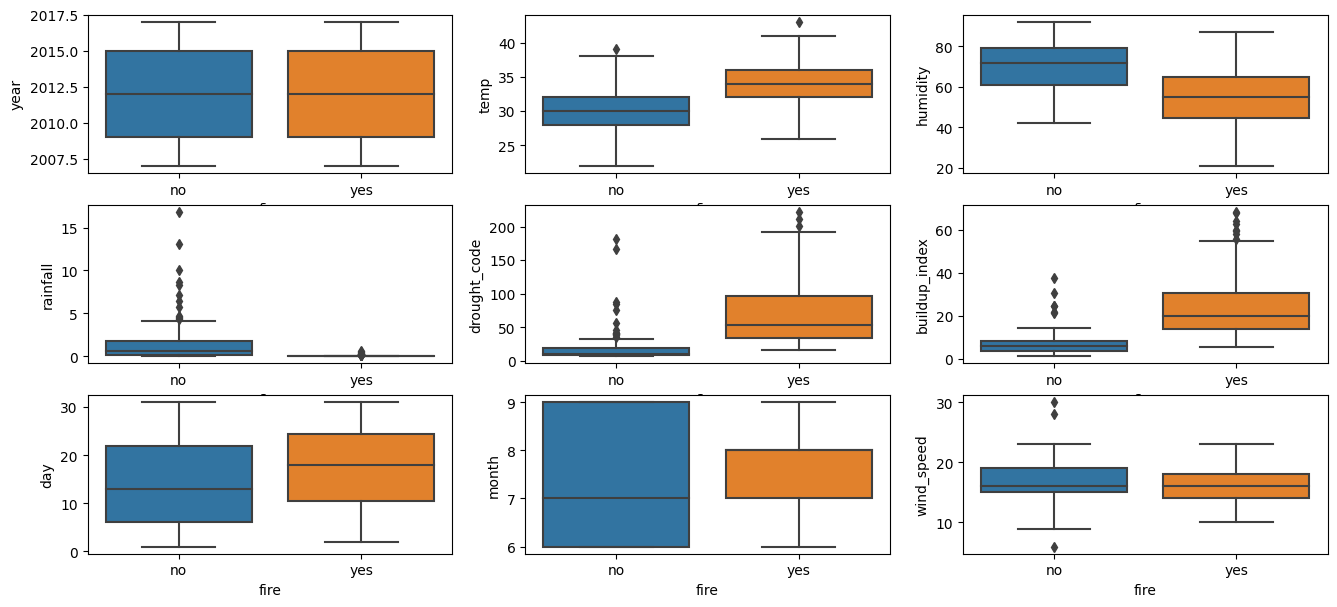

In [29]:
fig, axes = plt.subplots(3, 3, figsize=(16, 7))

for i, col in enumerate(df.columns):
    if col == 'fire': continue
    
    sns.boxplot(data=df, x='fire', y=col, ax=axes[int((i-1)/3)][(i-1)%3])

# Data Cleaning and Nnormalising

In [30]:
# cleaning process

# to encode target
dict_fire = {
    'no' : 0,
    'yes' : 1
}

df['encoded_fire'] = df['fire'].apply(lambda x: dict_fire[x])
ori_df = df.copy()

df = df.drop(['fire'], axis=1)
target = 'encoded_fire'

# normalise data
x = df.drop([target], axis=1).values # returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

df_normalized = pd.DataFrame(x_scaled, columns=df.drop([target], axis=1).columns)
df_normalized[target] = df[target]
df = df_normalized.copy()

# Checking if the dataset is imbalanced 

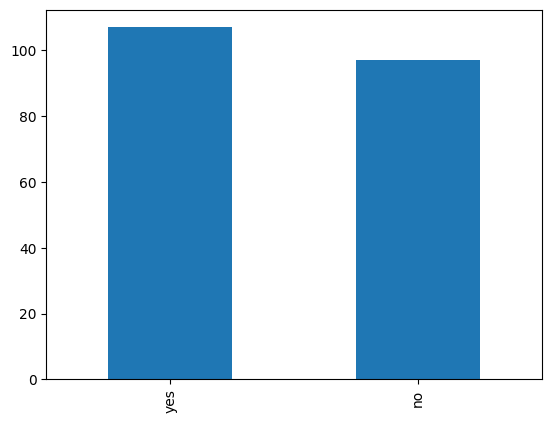

In [31]:
ori_df['fire'].value_counts().plot(kind = 'bar');

# Split dataset to train and test set

In [43]:
def train_test_split(df):
    
    test_size = int(len(df)/3)
    size_class_a = int(test_size/2)
    size_class_b = test_size - size_class_a
    
    # to stratify-split both classes to test set
    test_set_a = df[df[target]==1].sample(n=size_class_a, random_state=10)
    test_set_b = df[df[target]==0].sample(n=size_class_b, random_state=10)
    test_set = pd.concat([test_set_a, test_set_b], axis=0)
        
    train_set = df[~df.index.isin(test_set.index.values)]
    
    return train_set, test_set

In [47]:
train_set, test_set = train_test_split(df)

# Split train set to K-fold for cross validation

In [51]:
def cross_validation_split(df, split=5):
    
    fold_size = int(len(df)/split)
    fold_size_class_a = int(fold_size/2)
    fold_size_class_b = fold_size - fold_size_class_a
    
    kfold_split = []
    
    for i in range(split):
        if i == split - 1:
            kfold_split.append(df)
            return kfold_split
        
        # to stratify-split both classes to test set
        foldtest_set_a = df[df[target]==1].sample(n=fold_size_class_a, random_state=10)
        foldtest_set_b = df[df[target]==0].sample(n=fold_size_class_b, random_state=10)
        foldtest_set = pd.concat([foldtest_set_a, foldtest_set_b], axis=0)
        df = df[~df.index.isin(foldtest_set.index.values)]
        
        kfold_split.append(foldtest_set)
        
dfs = cross_validation_split(train_set, split=5)

# Custom MLP

In [70]:
class CustomMLP:
    def __init__(self, X_train, y_train, epoch=5, lr=1e-5, threshold=0.5, layer=[4,4]):
        '''
        lr: learning rate
        threshold: to get the final class
        layer: len(layer) <- number of hidden layers while element in layer indicates the number of neurons in each layer
        X_train: features of training data
        y_train: label of training data
        '''
        np.random.seed(10)
        
        self.Weights = []
        self.Biases = []
        
        self.FF_Output = []
        self.BP_Error = []
        
        self.loss = []
        self.acc = []
        
        self.X = X_train
        self.y = y_train
        
        self.lr = lr
        self.epoch = epoch
        self.threshold = threshold
        
        self.pred = []
        
        layer.insert(0, X_train.shape[1]) #add input layer
        layer.append(1) #add output layer
        for i in range(1, len(layer)):
            if i == len(layer)-1:
                #xavier for sigmoid
                self.Weights.append(np.random.randn(layer[i-1]) * np.sqrt(1/layer[i-1]))
            else:
                #he for relu
                self.Weights.append(np.random.randn(layer[i], layer[i-1]) * np.sqrt(2/layer[i-1]))
            self.Biases.append(np.random.rand(layer[i]))
            
        self.hiddenLayer = layer[1:-1]
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def deriv_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return np.maximum(0, x) #>0, x; <0, 0

    def deriv_relu(self, x):
        return np.heaviside(1, x) #>=0, 1; <0, 0
    
    def feedforward(self, x):
        self.FF_Output = []
        
        self.FF_Output.append(self.relu(np.dot(self.Weights[0], x) + self.Biases[0]))
        
        for i in range(1, len(self.hiddenLayer)):                                
            self.FF_Output.append(self.relu(np.dot(self.Weights[i], self.FF_Output[i-1]) + self.Biases[i]))
         
        self.FF_Output.append(self.sigmoid(np.dot(self.Weights[len(self.FF_Output)], self.FF_Output[-1]) + self.Biases[len(self.FF_Output)]))
        
        
    def backpropagation_error(self, y):
        #start from last to first layer
        self.BP_Error = []
        
        z = self.FF_Output
        self.BP_Error.append((z[-1] - y) * self.deriv_sigmoid(z[-1]))
        
        self.BP_Error.append(self.BP_Error[0][0]*self.Weights[-1] * self.deriv_relu(z[-2]))
        
        for i in range(1, len(z)-1): 
            self.BP_Error.append(np.dot(self.BP_Error[i], self.Weights[len(z)-1-i]) * self.deriv_relu(z[len(z)-2-i]))

        #flip to [first layer, last layer]
        self.BP_Error = np.flip(self.BP_Error, 0)
                        
    def gradient_descent(self, x):
        self.Weights[0] -= self.lr * np.kron(self.BP_Error[0], x).reshape(self.hiddenLayer[0], self.X.shape[1])
        self.Biases[0] -= self.lr * self.BP_Error[0]
        
        for i in range(1, len(self.Weights)-1):
            self.Weights[i] -= self.lr * np.kron(self.BP_Error[i], self.FF_Output[i-1]).reshape(self.hiddenLayer[i], self.hiddenLayer[i-1])
            self.Biases[i] -= self.lr * self.BP_Error[i]
 
        self.Weights[-1] -= self.lr * np.kron(self.BP_Error[-1], self.FF_Output[-2]).reshape(self.hiddenLayer[-1])
        self.Biases[-1] -= self.lr * self.BP_Error[-1]

    def Fit(self, ori_train, test, y_test):
        test_acc = []
        for e in range(self.epoch):
            self.loss = []
            pred = []
            
            for i in range(len(self.X)):
                self.feedforward(self.X[i])
                
                self.loss.append((self.FF_Output[-1] - self.y[i]) ** 2)
                pred.append(1 if self.FF_Output[-1] >= self.threshold else 0)

                self.backpropagation_error(self.y[i])
                self.gradient_descent(self.X[i])
                
            test_p, test_pp = self.Predict(test)
            test_acc.append(self.getAccuracy(test_p, y_test))
            
            ori_train[f'loss_e{e+1}'] = [i[0] for i in self.loss]
            ori_train[f'pred_e{e+1}'] = pred
            
        return ori_train, test_acc
    
    def Predict(self, X_test):
        pred = []
        pred_prob = []
        
        for i in range(len(X_test)):
            self.feedforward(X_test[i])
            
            pred_prob.append(self.FF_Output[-1])
            pred.append(1 if self.FF_Output[-1] >= self.threshold else 0)
            
            accuracy = pred[i]
            
        return pred, pred_prob
    
    def getAccuracy(self, pred, actual):
        total = 0
        actual = list(actual)
        for i in range(len(actual)):
            if pred[i] == actual[i]:
                total += 1
                
        return total/len(actual)

# To save the training and prediction output

In [57]:
def saveTrainOutput(results, filename='train_results.txt'):
    results.to_csv(filename, sep='\t', index=False)
    print(f"successfully saved training results as {filename}.")
    
def saveTestOutput(results, filename='test_results.txt'):
    results.to_csv(filename, sep='\t', index=False)
    print(f"successfully saved testing results as {filename}.")
    
def getOriginalDataset(train_set, test_set):
    
    ori_train = ori_df[ori_df.index.isin(train_set.index.values)].reindex(train_set.index)
    ori_test = ori_df[ori_df.index.isin(test_set.index.values)].reindex(test_set.index)
    
    return ori_train, ori_test

# To use the custom model

## Hyperparameters setting

In [58]:
def setHyperParameters():
    lr = 1e-1
    epoch = 10
    layer = [4, 4]
    threshold = 0.5
    
    return lr, epoch, layer, threshold

In [73]:
def crossValidation(dataset):
    for k, ktest in enumerate(dataset):
        lr, epoch, layer, threshold = setHyperParameters()
        
        ktrain = train_set[~train_set.index.isin(ktest.index.values)]
        ktest = ktest.sample(frac=1, random_state=10)
        
        X_train, X_test = ktrain.drop(target, axis=1).to_numpy(), ktest.drop(target, axis=1).to_numpy()
        y_train, y_test = ktrain[target].to_numpy(), ktest[target].to_numpy()
        
        ori_train, ori_test = getOriginalDataset(ktrain, ktest)
        
        model = CustomMLP(X_train, y_train, lr = lr, epoch = epoch, threshold = threshold, layer = layer)
        model.Fit(ori_train, X_test, y_test)
        
        train_pred, pred_prob = model.Predict(X_train)
        test_pred, pred_prob = model.Predict(X_test)
        
        print(f"""@ Fold{k+1}: loss = {np.mean(model.loss)}
        train accuracy = {model.getAccuracy(train_pred, y_train)}
        test accuracy = {model.getAccuracy(test_pred, y_test)}
        """)
        
crossValidation(dfs)

@ Fold1: loss = 0.13392771892509273
        train accuracy = 0.8348623853211009
        test accuracy = 0.8148148148148148
        
@ Fold2: loss = 0.14507364691723432
        train accuracy = 0.8256880733944955
        test accuracy = 0.8518518518518519
        
@ Fold3: loss = 0.1429879912052776
        train accuracy = 0.8440366972477065
        test accuracy = 0.8148148148148148
        
@ Fold4: loss = 0.14956847097233056
        train accuracy = 0.7706422018348624
        test accuracy = 0.7407407407407407
        
@ Fold5: loss = 0.12895145395394858
        train accuracy = 0.8518518518518519
        test accuracy = 0.7857142857142857
        


In [74]:
lr, epoch, layer, threshold = setHyperParameters()

test_set = test_set.sample(frac=1, random_state = 10)
X_train, X_test = train_set.drop(target, axis=1).to_numpy(), test_set.drop(target, axis=1).to_numpy()
y_train, y_test = train_set[target].to_numpy(), test_set[target].to_numpy()

ori_train, ori_test = getOriginalDataset(train_set, test_set)

model = CustomMLP(X_train, y_train, lr=lr, epoch=epoch, threshold=threshold, layer=layer) 
trainResults, CusMLP_test_acc = model.Fit(ori_train, X_test, y_test)

train_pred, train_pred_prob = model.Predict(X_train)
test_pred, test_pred_prob = model.Predict(X_test)
ori_train['pred'] = train_pred
ori_test['pred'] = test_pred
ori_test['pred_prob'] = [i[0] for i in test_pred_prob]

print(f"""Final Training @ loss = {np.mean(model.loss)}
train accuracy = {model.getAccuracy(train_pred, y_train)}
            test accuracy = {model.getAccuracy(test_pred, y_test)}
            """)

# print(train_pred)

saveTrainOutput(trainResults)
saveTestOutput(ori_test)

Final Training @ loss = 0.13344842703992035
train accuracy = 0.8529411764705882
            test accuracy = 0.8088235294117647
            
successfully saved training results as train_results.txt.
successfully saved testing results as test_results.txt.


In [78]:
train_results_txt = pd.read_csv('train_results.txt', delimiter="\t")
train_results_txt.shape

(136, 32)

In [80]:
loss_e = [col for col in train_results_txt if col.startswith('loss_e')]
pred_e = [col for col in train_results_txt if col.startswith('pred_e')]

CusMLP_loss = []
CusMLP_train_acc = []

for i in range(len(loss_e)):
    
    CusMLP_loss.append(sum(list(train_results_txt[loss_e[i]])) / train_results_txt.shape[0])
    
    pred = list(train_results_txt[pred_e[i]])
    
    total = 0
    
    actual = list(train_results_txt[target])
    
    for i in range(len(actual)):
        if pred[i] == actual[i]:
            total += 1
            
    CusMLP_train_acc.append(total/len(actual))

In [82]:
from sklearn.metrics import confusion_matrix

test_results_txt = pd.read_csv('test_results.txt', delimiter="\t")
test_results_txt.head()

actual = list(test_results_txt[target])
pred = list(test_results_txt['pred'])

CusMLP_CM = confusion_matrix(actual, pred)

CusMLP_ytest = np.array(actual)
CusMLP_ytest_prob = np.array(list(test_results_txt['pred_prob']))

In [86]:
from sklearn.neural_network import MLPClassifier

for k, ktest in enumerate(dfs):
    lr, epoch, layer, threshold = setHyperParameters()
    
    ktrain = train_set[~train_set.index.isin(ktest.index.values)]
    ktest = ktest.sample(frac=1, random_state=10)
    
    X_train, X_test = ktrain.drop(target, axis=1).to_numpy(), ktest.drop(target, axis=1).to_numpy()
    y_train, y_test = ktrain[target].to_numpy(), ktest[target].to_numpy()
    
    clf = MLPClassifier(hidden_layer_sizes=tuple(layer), random_state=10, shuffle=False,
                       max_iter = 10,
                       solver='sgd', batch_size=1,
                       learning_rate_init=lr)
    clf.fit(X_train, y_train)
    
    print(f"@ Fold{k+1}: loss = {np.mean(clf.loss_curve_)}\
    train accuracy = {clf.score(X_train, y_train)}\
    test accuracy = {clf.score(X_test, y_test)}")

@ Fold1: loss = 0.8082933364009979    train accuracy = 0.5504587155963303    test accuracy = 0.48148148148148145
@ Fold2: loss = 0.8240726258182143    train accuracy = 0.5504587155963303    test accuracy = 0.48148148148148145
@ Fold3: loss = 0.8057784213415559    train accuracy = 0.44954128440366975    test accuracy = 0.5185185185185185
@ Fold4: loss = 0.7849455631316078    train accuracy = 0.5504587155963303    test accuracy = 0.48148148148148145
@ Fold5: loss = 0.8131640799373742    train accuracy = 0.48148148148148145    test accuracy = 0.75


In [89]:
test_set = test_set.sample(frac=1, random_state=10)
X_train, X_test = train_set.drop(target, axis=1).to_numpy(), test_set.drop(target, axis=1).to_numpy()
y_train, y_test = train_set[target].to_numpy(), test_set[target].to_numpy()

lr, epoch, layer, threshold = setHyperParameters()

clf = MLPClassifier(hidden_layer_sizes=tuple(layer), random_state=10, shuffle=False,
                    max_iter = 10,
                    solver='sgd', batch_size=1, learning_rate_init=lr)
clf.fit(X_train, y_train)

SkMLP_ypred_prob = clf.predict_proba(X_test)[::,1]
SkMLP_ytest = y_test

SkMLP_CM = confusion_matrix(clf.predict(X_test), y_test)

print(f"""Final Training @ loss = {np.mean(clf.loss_curve_)}
     train accuracy = {clf.score(X_train, y_train)}
     test accuracy = {clf.score(X_test, y_test)}
     """)

Final Training @ loss = 0.7677550881207836
     train accuracy = 0.5367647058823529
     test accuracy = 0.5
     


In [90]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(clf, X=X_train, y=y_train,
                                                        train_sizes = np.linspace(0.1, 1.0, 10))

SkMLP_loss = clf.loss_curve_
SkMLP_train_acc = np.mean(train_scores, axis =1)
SkMLP_test_acc = np.mean(test_scores, axis=1)

In [91]:
clf.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 1,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (4, 4),
 'learning_rate': 'constant',
 'learning_rate_init': 0.1,
 'max_fun': 15000,
 'max_iter': 10,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 10,
 'shuffle': False,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

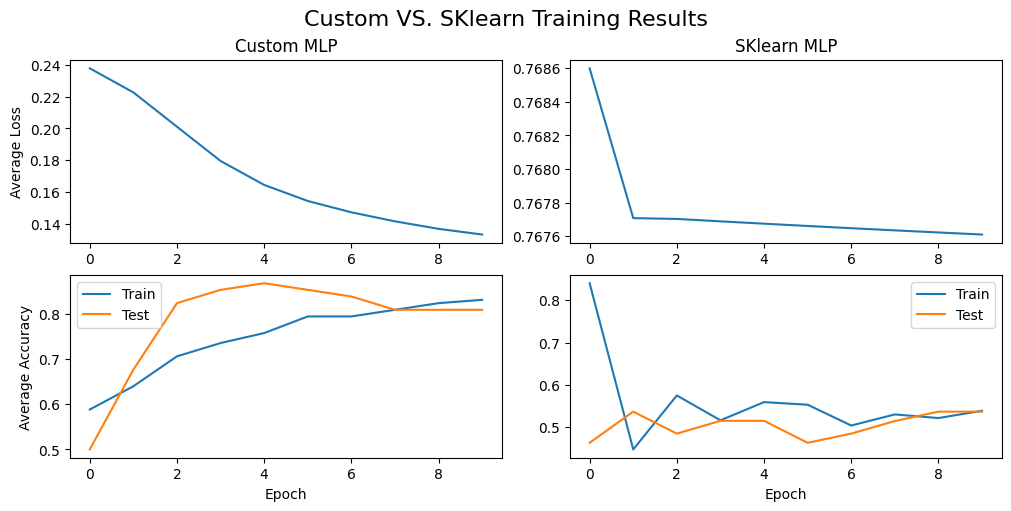

In [101]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True)
fig.suptitle('Custom VS. SKlearn Training Results', fontsize=16)

# plot for loss curve
axs[0, 0].plot(CusMLP_loss)
axs[0, 0].set_title("Custom MLP")
axs[0, 1].plot(SkMLP_loss)
axs[0, 1].set_title("SKlearn MLP")
axs[0, 0].set(ylabel='Average Loss')

# plot for accuracy learning curve
axs[1, 0].plot(CusMLP_train_acc, label="Train")
axs[1, 0].plot(CusMLP_test_acc, label="Test")
axs[1, 0].legend()

axs[1, 1].plot(SkMLP_train_acc, label="Train")
axs[1, 1].plot(SkMLP_test_acc, label="Test")
axs[1, 1].legend()

axs[1, 0].set(ylabel='Average Accuracy')
axs[1, 0].set(xlabel='Epoch')
axs[1, 1].set(xlabel='Epoch')

plt.show();

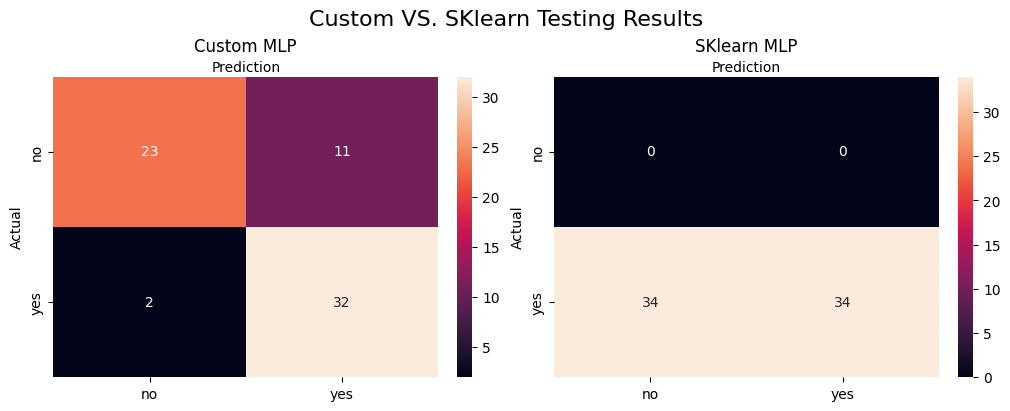

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
fig.suptitle('Custom VS. SKlearn Testing Results', fontsize=16)


ax = sns.heatmap(CusMLP_CM, annot=True, ax=axes[0])
ax.set(xlabel="Prediction", ylabel="Actual")
ax.xaxis.set_label_position('top')
ax.set_xticklabels(['no', 'yes'])
ax.set_yticklabels(['no', 'yes'])
ax.set_title("Custom MLP")


ax = sns.heatmap(SkMLP_CM, annot=True, ax=axes[1])
ax.set(xlabel="Prediction", ylabel="Actual")
ax.xaxis.set_label_position('top')
ax.set_xticklabels(['no', 'yes'])
ax.set_yticklabels(['no', 'yes'])
ax.set_title("SKlearn MLP");

In [107]:
from sklearn import metrics


plt.suptitle('Custom VS. SKlearn AUC-ROC Curve', fontsize=16)

SkMLP_fpr, SkMLP_tpr, _ = metrics.roc_curve(SkMLP_ytest,  SkMLP_ypred_prob)
SkMLP_auc = metrics.roc_auc_score(SkMLP_ytest, SkMLP_ypred_prob)
CusMLP_fpr, CusMLP_tpr, _ = metrics.roc_curve(CusMLP_ytest,  CusMLP_ypred_prob)
CusMLP_auc = metrics.roc_auc_score(CusMLP_ytest, CusMLP_ypred_prob)

#create ROC curve
plt.plot(SkMLP_fpr,SkMLP_tpr,label="SKlearn AUC="+str(SkMLP_auc))
plt.plot(CusMLP_fpr,CusMLP_tpr,label="Custom AUC="+str(round(CusMLP_auc, 3)))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

NameError: name 'CusMLP_ypred_prob' is not defined

<Figure size 640x480 with 0 Axes>